# Astropy tutorial: putting it all together

In this tutorial we'll go through how to use some of the features of `astropy` as well as the `astroquery` library.

We'll focus on Barnard's Star, which is a nearby star with a very high proper motion.

## Astroquery: Simbad
`astroquery` is a handy python library for accessing information from the online **Simbad** and **Vizier** databases.

Let's first load the **Simbad** interface and send a query for your favorite object.

In [1]:
from astroquery.simbad import Simbad
import astropy.units as u
from astropy.coordinates import SkyCoord

In [2]:
result = Simbad.query_object("Barnard's Star")
result

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
NAME Barnard's star,17 57 48.4997,+04 41 36.111,14,14,0.223,0.304,90,A,O,2018yCat.1345....0G


In [3]:
type(result)

astropy.table.table.Table

You'll see that this query returns an object with several columns but a single row. This object is in fact an `astropy.table` object.

### Exercise: 

1. Print the columns of the table using the `.columns` method of `astropy.table`.
2. Use the RA and Dec columns from the table to create a `SkyCoord` object.

## Dealing with FITS files: headers
Let's download two FITS images from the Very Large Telescope of the European Southern Observatory. These files are on the ASTRON FTP, but should they disappear in the future you can download them from the ESO archive (use http://archive.eso.org/cms/eso-data/eso-data-direct-retrieval.html with identifiers _FORS2.2003-04-11T08:49:16.002_ and _FORS2.2016-05-16T07:29:38.764_).

Again, let's start with importing some required libraries and download the two FITS images from the ASTRON FTP.

In [7]:
import urllib
import os

In [8]:
url_datafiles = ["ftp://ftp.astron.nl/outgoing/bassa/FORS2.2003-04-11T08:49:16.002.fits", 
                "ftp://ftp.astron.nl/outgoing/bassa/FORS2.2016-05-16T07:29:38.764.fits"]
# Download file if it does not exist
for url_datafile in url_datafiles:
    fname = os.path.basename(url_datafile)
    if not os.path.isfile(fname):
        urllib.request.urlretrieve(url_datafile, fname)

To open a FITS file we'll need to import the `fits` module of `astropy.io`. When opening a FITS file, it return a list of _header data units_ (HDUs), where each HDU contains a header and associated data.

In [9]:
from astropy.io import fits

In [10]:
hdu = fits.open("FORS2.2003-04-11T08:49:16.002.fits")

In [11]:
len(hdu)

1

In [12]:
hdu[0].header

 [astropy.io.fits.verify]


SIMPLE  =                    T / Standard FITS format (NOST-100.0)              
BITPIX  =                   16 / # of bits storing pix values                   
NAXIS   =                    2 / # of axes in frame                             
NAXIS1  =                 2048 / # pixels/axis                                  
NAXIS2  =                 1034 / # pixels/axis                                  
ORIGIN  = 'ESO     '           / European Southern Observatory                  
DATE    = '2003-04-11T08:49:20.132' / UT date when this file was written        
MJD-OBS =       52740.36754632 / MJD start (2003-04-11T08:49:16.002)            
DATE-OBS= '2003-04-11T08:49:16.001' / Date of observation                       
EXPTIME =               2.9921 / Total integration time                         
EXTNAME = 'CHIP1   '           / Extension name                                 
CRVAL1  =            269.45200 / value of ref pixel                             
CRPIX1  =               1026

In [13]:
hdu[0].data

array([[215, 212, 206, ..., 212, 213, 206],
       [210, 206, 214, ..., 211, 211, 209],
       [211, 212, 212, ..., 206, 212, 209],
       ...,
       [220, 226, 231, ..., 226, 224, 223],
       [ 99,  99, 113, ..., 109, 130, 113],
       [212, 210, 208, ..., 220,  99, 212]], dtype=uint16)

In [14]:
hdu[0].data.shape

(1034, 2048)

FITS headers from ESO instruments contain a lot of information, which is useful when analysing the data. 

Here are some example fields in the headers:

In [15]:
print("Telescope position: ", hdu[0].header["HIERARCH ESO TEL GEOLAT"], hdu[0].header["HIERARCH ESO TEL GEOLON"], hdu[0].header["HIERARCH ESO TEL GEOELEV"])

Telescope position:  -24.6253 -70.4022 2648.0


In [16]:
print("Alt/Az at observation start: ", hdu[0].header["HIERARCH ESO TEL ALT"], hdu[0].header["HIERARCH ESO TEL AZ"])

Alt/Az at observation start:  59.569 196.74


### Exercise:
1. Use the telescope position to define an `EarthLocation` object. Make sure to load the correct `astropy` module.
2. Use the observation start time to define a `Time` object.
3. Use the RA and DEC keywords to define a `SkyCoord` object.
4. Use all these objects to check if the Alt/Az in the header is correct.

## Dealing with FITS files: data and world coordinate systems
As you could see earlier, the FITS file has a 2D data array of 1034x2048 pixels. Let's play a bit with that.

In [25]:
hdu[0].data.shape

(1034, 2048)

In [26]:
type(hdu[0].data)

numpy.ndarray

In [27]:
type(hdu[0].data[0, 0])

numpy.uint16

In [28]:
hdu[0].header["BITPIX"]

16

Conveniently, the data from a FITS file HDU is provided as `numpy` array of shape 1034 by 2048 pixels. Each pixel is stored as a 16 bit integer, as conveyed by the __BITPIX__ keyword in the FITS header.

Let's plot the image.

In [29]:
import matplotlib.pyplot as plt

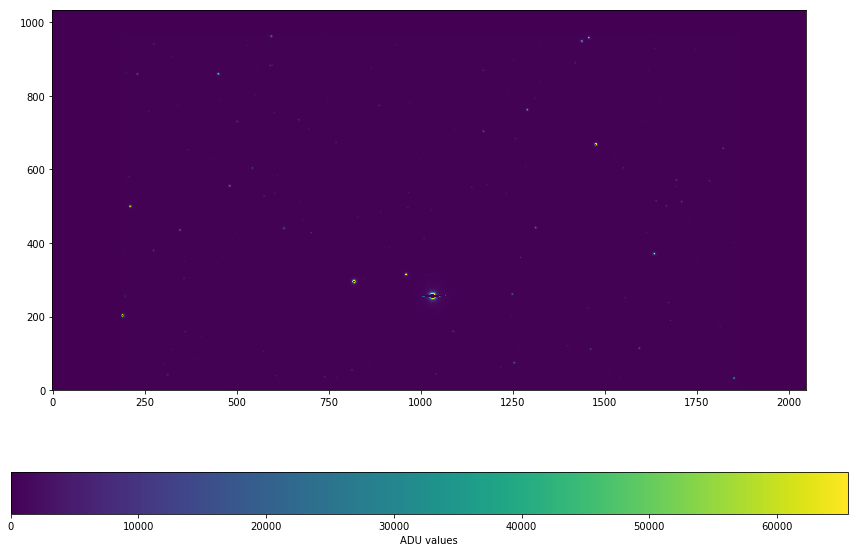

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
img = ax.imshow(hdu[0].data, origin="lower", aspect=1, interpolation=None)
cbar = fig.colorbar(img, orientation="horizontal")
cbar.set_label("ADU values")

### Exercise:
`imshow` uses the image minimum and maximum to set the dynamic range.
1. Take a cross cut of a single row or column to estimate more sensible values.
2. Create the plot using your estimates (`vmin` and `vmax` keywords of `imshow`)

The FITS image contains a _World Coordinate System_ (WCS) which relates pixel positions to celestial coordinates and vice versa.

The following commands load the WCS.

In [33]:
from astropy.wcs import WCS

In [34]:
wcs = WCS(hdu[0].header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [35]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 269.452  4.69339  
CRPIX : 1026.5  120.8  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -7.0017e-05  7.0017e-05  
NAXIS : 2048  1034

We can now use the WCS to plot WCS axes on the plot.

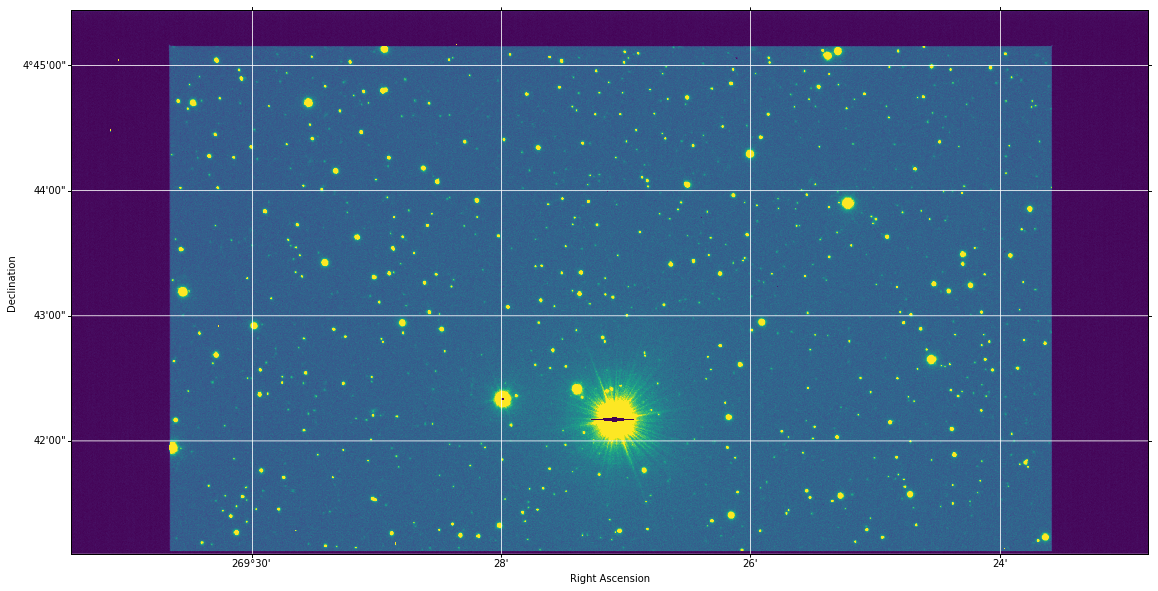

In [38]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(hdu[0].data, vmin=200, vmax=700, origin="lower", aspect=1, cmap="viridis")
ax.grid(color="white")
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")

## Astroquery: Vizier
Let's import the `Vizier` module from `astroquery`.

In [41]:
from astroquery.vizier import Vizier

### Exercise: 
1. Use the `find_catalogs` method from `Vizier` to search for the GAIA DR2 catalog.
2. Use the Vizier.query_region method to query the GAIA DR2 catalog (I/345) for objects within 0.1 degrees around Barnard's Star.

In [46]:
Vizier.ROW_LIMIT = -1
result = Vizier.query_region("Barnard's Star", radius=0.1*u.deg, catalog="I/345/gaia2")
result

TableList with 1 tables:
	'0:I/345/gaia2' with 32 column(s) and 2336 row(s) 

This result contains the following columns:

In [47]:
data = result[0]
data.columns

<TableColumns names=('RA_ICRS','e_RA_ICRS','DE_ICRS','e_DE_ICRS','Source','Plx','e_Plx','pmRA','e_pmRA','pmDE','e_pmDE','Dup','FG','e_FG','Gmag','e_Gmag','FBP','e_FBP','BPmag','e_BPmag','FRP','e_FRP','RPmag','e_RPmag','BP-RP','RV','e_RV','Teff','AG','E_BP-RP_','Rad','Lum')>

A cool feature of this table is that it contains information about the unit of each column.

In [48]:
print(data["RA_ICRS"].unit)
print(data["pmRA"].unit)

deg
mas / yr


### Exercise: 
1. Use the RA and DEC columns to define `SkyCoord` objects for the entire table, now using the table units.
2. Use these coordinates to overplot the GAIA stars on the FITS image. Use the sizes of the markers to denote the brightness of these stars. Tips: use the size in `plt.scatter` to change the marker sizes, use the `Gmag` column for magnitudes and convert them to size $r$ using $r=r_\mathrm{max}+(r_\mathrm{min}-r_\mathrm{max})(M-M_\mathrm{min})/(M_\mathrm{max}-M_\mathrm{min})$. Good values for this exercise are $M_\mathrm{min}=5$, $M_\mathrm{max}=20$, $r_\mathrm{min}=1$ and $r_\mathrm{max}=200$. Use the `transform=ax.get_transform("world")` keyword to force plotting in world coordinate systems.
3. Make the same figure for the second FITS file. Can you identify Barnard's Star?

## Parallax and distances
The GAIA catalog has a parallax column, `Plx`. 

In [70]:
data["Plx"]

1.5473
-0.3391
-0.9632
0.5543
0.4149
-1.7725
0.4952
0.4355
0.2315
0.5453
0.4441


This column is a `MaskedColumn` in `astropy.Table`, which allows data entries to be missing. See http://docs.astropy.org/en/stable/table/masking.html. You'll also see that some parallax values are negative, which is physically impossible, but an artifact of the GAIA processing of low signal-to-noise objects. 

To convert a `MaskedColumn` to a regular `Column`, we can fill in the values which are missing, like so:

In [73]:
data["Plx"].fill_value = 1e-2 # Some small value
plx = data["Plx"].filled()
plx

1.5473
-0.3391
-0.9632
0.5543
0.4149
-1.7725
0.4952
0.4355
0.2315
0.5453
0.4441


In [74]:
from astropy.coordinates import Distance

In [75]:
Distance?

The `Distance` class of `astropy.coordinates` is a useful way of converting these parallaxes into distances.

### Exercise: 
1. Use the `Distance` class to convert the GAIA parallax values to distances. Note that `Distance` can not take an `astropy.Column` object, so you can change it to a `Quantity` using `plx.to(plx.unit)`.

## Space motion
Since version 3 of `astropy` it is possible to propagate objects based on their position, distance, proper motion and radial velocity. The GAIA DR2 provides most of this information. The following exercises will show how to do this.

First, let's load the required modules

In [78]:
import numpy as np
from astropy.time import Time

Let's set the epoch of the GAIA DR2 positions.

In [79]:
epoch = Time(2015.5, format="decimalyear")

In [80]:
epoch.isot

'2015-07-02T11:59:59.500'

In [81]:
data[0]

RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Source,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,FG,e_FG,Gmag,e_Gmag,FBP,e_FBP,BPmag,e_BPmag,FRP,e_FRP,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
deg,mas,deg,mas,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,e-/s,e-/s,mag,mag,e-/s,e-/s,mag,mag,e-/s,e-/s,mag,mag,mag,km / s,km / s,K,mag,mag,Rsun,Lsun
float64,float64,float64,float64,int64,float64,float32,float64,float32,float64,float32,uint8,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float32,float32,float64
269.49799018493,0.8838,4.60642664546,1.0138,4472795400378951040,1.5473,0.9899,-0.797,1.629,-8.404,1.771,0,114.5,1.459,20.5410,0.0138,58.72,13.18,20.9295,0.2437,90.12,11.14,19.8748,0.1342,1.0547,--,--,--,--,--,--,--


The columns we are interested in are **RA_ICRS** and **DE_ICRS**. We have already defined the distances, so all we need further is **pm_RA**, **pmDE**, and **RV**.

However, we need to clean up some columns, as distances will have NaN values for objects which had negative parallaxes, and not all objects will have radial velocities.

In [82]:
d[np.isnan(d)] = 10000*u.pc

In [83]:
data["RV"].fill_value = 0.0*u.km/u.s
rv = data["RV"].filled()

### Exercise:
1. Define a 3D position and velocity using `ra`, `dec`, `distance`, `pm_ra_cosdec`, `pm_dec` and `radial_velocity` as inputs to a `SkyCoord` object, defined at a particular time `obstime`.
2. Use the `apply_space_motion` function of a `SkyCoord` object to propagate the position and velocity to another time.
3. Select Barnard's Star based on its high proper motion.
4. Apply the space motion to the two epochs of the FITS images and overlay the propagated positions on the FITS images. Denote Barnard's Star in the images.